In [1]:
import tensorflow as tf
from functools import partial
from configuredEstimator import confRegressorEstimator
import numpy as np
import sys
sys.path.append("/jup/projects/mtgtools2/")  # ensure we find the MTG libraries
import pymtg.fci.esl.training_data as esl
import pymtg
from pathlib import Path

MNT_DIR = Path("/scratch/andreu/")
RETINAS_JSON = Path(pymtg.__file__).parent.parent / "test/FCI_ESL/pyesl/config/retinas.json"
ESL_PATH = MNT_DIR / "ESL/nc/output/20170615T152646/ch123/"
FCI_PATH = MNT_DIR / "ESL/nc/swaths/"

#model_name = '/scratch/tensorboard/CONV2.yml_collapsed_size_200_batches_50_train_steps_1000_20180814T142507'
#MODEL = 'CONV2.yml'
model_name = '/scratch/tensorboard/CONV3.yml_not_collapsed_size_500_batches_1_train_steps_1000_20180816T082506'
MODEL = 'CONV3.yml'
run_config= tf.estimator.RunConfig(model_dir=model_name)
                        
# create the estimator
esl_regressor = confRegressorEstimator(MODEL, config=run_config)     

{'config': <tensorflow.python.estimator.run_config.RunConfig object at 0x7f35f486c780>}
INFO:tensorflow:Using config: {'_model_dir': '/scratch/tensorboard/CONV3.yml_not_collapsed_size_500_batches_1_train_steps_1000_20180816T082506', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3654504710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [5]:
import matplotlib.pyplot as plt

def input_fn(size, train_or_test='train', collapsed=False, num_batches=1, mode=tf.estimator.ModeKeys.TRAIN, plot_data=False):
    """
    Input function that serves data to the estimator.
    If not collapsed it will return x={features:(size*num_batches, 129, 186), y=(size*num_batches, 113).
    If collapsed, it will return x={features:(num_batches, 129, 186+size)}, y=(num_batches, 113xsize)
    The argument train_or_test should be set to train for the moment, as test is not validated.
    """
    print("Calling input_fn with collapsed={}, num_batches={}, size={}".format(collapsed, num_batches, size))
    files = esl.prepare_training_data(FCI_PATH, ESL_PATH, 0, str(RETINAS_JSON))
    out_batch = list(files[train_or_test].batches("ch123", size, 20000, num_batches=num_batches))  # use always 'train', 'test' is not validated
    if collapsed:
        features = np.array([collapse_scene(out_batch[i][0]) for i in range(num_batches)])
        labels = np.array([out_batch[i][1].flatten() for i in range(num_batches)])
    else:
        features = np.concatenate([out_batch[i][0] for i in range(len(out_batch))], axis=0)  # flatten into a (num_batches*size, 129, 113)
        labels = np.concatenate([out_batch[i][1] for i in range(len(out_batch))], axis=0)
    if plot_data:  # for validation purposes during prediction, will plot only the first image
        if collapsed:
            for f in features:
                plt.imshow(f)
                plt.show()
            for l in labels:
                plt.imshow(l.reshape(out_batch[0][1].shape))
                plt.show()
        else:
            plot_scene(features)
            plot_esl(labels.T)    
    dataset = tf.data.Dataset.from_tensors(({'x': features}, labels))
    return dataset

def collapse_scene(scene, step=1):
    col_scene = scene[0]
    for s in scene[1:]:
        col_scene = np.insert(col_scene, -step, s.transpose()[-step], axis=1)  # create single input scene.
    return col_scene


def plot_scene(scene):
    plt.imshow(collapse_scene(scene))
    plt.title('Input scene')
    plt.show()

def plot_esl(esl):
    plt.imshow(esl)
    plt.title('ESL')
    plt.show()

Calling input_fn with collapsed=False, num_batches=1, size=500


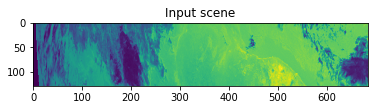

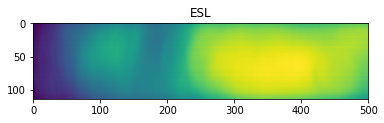

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/tensorboard/CONV3.yml_not_collapsed_size_500_batches_1_train_steps_1000_20180816T082506/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


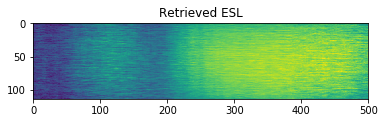

In [10]:
SIZE = 500
COLLAPSED = False

foo = esl_regressor.predict(input_fn=partial(input_fn, size=SIZE, num_batches=1, collapsed=COLLAPSED, plot_data=True))
pred_esl = np.array([p['predictions'] for p in foo])

plt.imshow(pred_esl.reshape((SIZE, 113)).T)
plt.title('Retrieved ESL')
plt.show()